# Análise dos dados de empréstimos de biblioteca durante o ano de 2023

### Origem dos dados

Os dados foram fornecidos pela Coordenadoria Geral de Biblioteca (CGB) em diálogo via e-mail no primeiro semestre de 2024, e se referem aos empréstimos de livros e suas datas de empréstimos durante o ano de 2023.

____

### Análise dos dados

#### Importação e carregamento da base de dados

Os dados estão armazenados no formato `.csv` no arquivo `base_de_dados_biblioteca.csv`, que foram convertidos de uma tabela `.xlsx`.

In [2]:
# Instalação de dependências
%pip install seaborn
%pip install wordcloud
%pip install scikit-learn
%pip install -U spacy
!python -m spacy download pt_core_news_sm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 11.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [3]:
# Importação de bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import spacy
nlp = spacy.load('pt_core_news_sm')

import wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error

In [4]:
# Etiquetas úteis
meses_abr = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

In [5]:
# Carregando dados .csv usando Pandas
url = "data/base_de_dados_biblioteca.csv"
df = pd.read_csv(url)

**Visualizando as primeiras linhas da base**

In [6]:
df.head()

,data-emprestimo,data-para-devolucao,data-devolucao,tombo,autor,titulo,lugar-publicacao,editor,ano,edicao,assunto
0,2/1/2023,12/1/2023,3/1/2023,96657,"Atkins, P. W 1940- Peter William",Físico-química /,Rio de Janeiro :,LTC,c2008,8. ed. -,Físico-química.; Física.; Química.; Equilibrio...
1,2/1/2023,16/1/2023,16/1/2023,80451,"Morin, Edgar, 1921-",Os sete saberes necessários à educação do futu...,São Paulo:,Cortez,2005,10. ed. -,Teoria do conhecimento.; Abordagem interdiscip...
2,2/1/2023,16/1/2023,16/1/2023,93418,"Gadotti, Moacir, 1941-",Pensamento pedagógico brasileiro /,São Paulo :,Ática,2004,"8. ed., rev. e ampl. -",Educação--Brasil.; Educação--Aspectos político...
3,2/1/2023,13/3/2023,6/2/2023,93292,"Ball, David W., 1962.",Físico-química /,São Paulo :,Cengage Learning; Thomson,2005-2006,NaN,Físico-química.; Química.; Termodinâmica.; Mov...
4,3/1/2023,13/1/2023,3/1/2023,76924,"Atkins, P. W 1940- Peter William",Físico-química /,Rio de Janeiro :,LTC,c2003,7. ed. -,Físico-química.


Imediatamente pode-se notar que os dados da coluna `Lugar de publicação` são sufixados de um " :".

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8897 entries, 0 to 8896
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   data-emprestimo      8897 non-null   object
 1   data-para-devolucao  8897 non-null   object
 2   data-devolucao       8305 non-null   object
 3   tombo                8817 non-null   object
 4   autor                7586 non-null   object
 5   titulo               8897 non-null   object
 6   lugar-publicacao     8890 non-null   object
 7   editor               8887 non-null   object
 8   ano                  8893 non-null   object
 9   edicao               5175 non-null   object
 10  assunto              8870 non-null   object
dtypes: object(11)
memory usage: 764.7+ KB


#### Colunas

- `data-emprestimo` **Data do empréstimo**
  - Data no formato dd/mm/YYYY em que o livro foi emprestado pela biblioteca;

- `data-para-devolucao` **Data marcada para devolução**
  - Data no formato dd/mm/YYYY em que o livro deveria ser devolvido para a biblioteca;

- `data-devolucao` **Data em que foi devolvido**
  - Data no formato dd/mm/YYYY em que o livro foi, de fato, devolvido;
  - Notamos que as colunas 0 e 1 (Data do empréstimo e Data marcada para devolução) estão completamente preenchidas (8897 itens). Por outro lado, a coluna 2, **Data em que foi devolvido**, que possui 592 elementos nulos, é vazia quando os empréstimos não tiveram devolução até o dia 08/04/2024;

- `tombo` **Tombo**
  - Código do tombo que identifica o livro no acervo;

- `autor` **Autor**
  - Nome do autor da obra;

- `titulo` **Título**
  - Título do livro emprestado, sufixado de uma " /";

- `lugar-publicacao` **Lugar de publicação**
  - Local de publicação, sufixado de um " :";

- `editor` **Editor**
  - Editora que publicou a obra;

- `ano` **Ano**
  - Ano de publicação, com diferentes padrões;

- `edicao` **Edição**
  - Número da edição, ou vazio caso o dado não exista;

- `assunto` **Assunto**
  - Temas separados por ";" sobre os quais o livro discorre.

*Algumas sugestões anotadas em diálogo com o professor*
> - dia da semana afetando a data de entrega
> - extrair dias da semana, mês das colunas 0, 1 e 2
> - nuvem de palavras
> - identificação de livros / temas com destaque (que mais foram emprestados, atrados, etc) 

#### Dados nulos

In [8]:
df.isnull().sum()

a = 'teste /'
print(a.replace(' /', ''))

teste


#### Sobre as datas de empréstimos

As colunas `data-emprestimo` e `data-para-devolucao` são imprescindíveis para a compreensão do comportamento dos empréstimos. Para isso, vejamos seu comportamento.

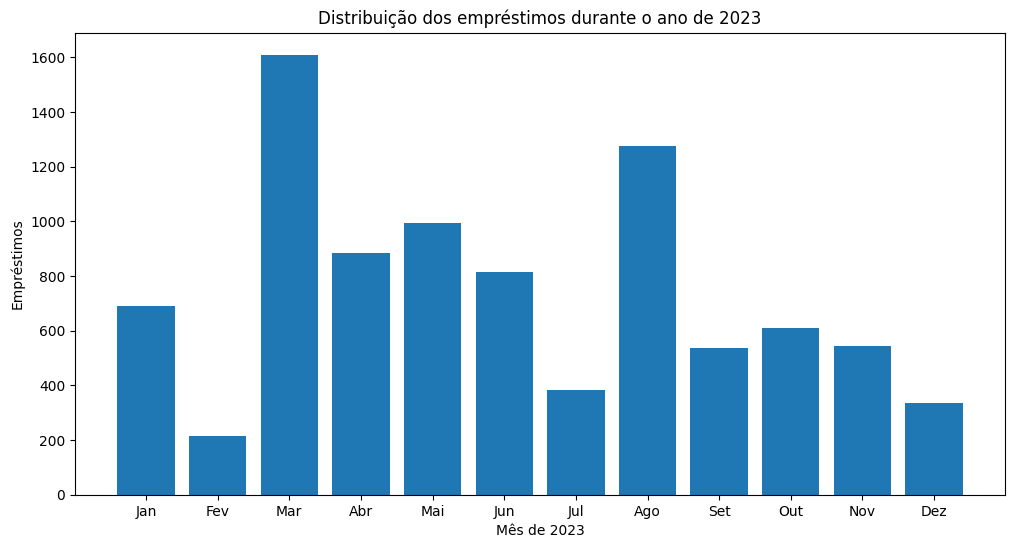

In [39]:
# Converte o tipo de dado de string para data
df['data-emprestimo'] = pd.to_datetime(df['data-emprestimo'], format='%d/%m/%Y')
# Converte o tipo de dado de string para data
df['data-para-devolucao'] = pd.to_datetime(df['data-para-devolucao'], format='%d/%m/%Y')
# Converte o tipo de dado de string para data
df['data-devolucao'] = pd.to_datetime(df['data-devolucao'], format='%d/%m/%Y')
# Cria uma coluna para agregar os empréstimos de cada mês
df['mes-emprestimo'] = df['data-emprestimo'].dt.month
# Remove barra do final do título
df['titulo'] = df['titulo'].str.replace(' /', '')

# Conta os títulos emprestados por mês
df_data_emprestimo = df[['mes-emprestimo', 'titulo']].groupby('mes-emprestimo').count().reset_index()

# plotando gráfico
plt.figure(figsize=(12, 6))
plt.bar(df_data_emprestimo['mes-emprestimo'], df_data_emprestimo['titulo'])
plt.title("Distribuição dos empréstimos durante o ano de 2023")
plt.xlabel("Mês de 2023")
plt.xticks(df_data_emprestimo['mes-emprestimo'], meses_abr)
plt.ylabel("Empréstimos")
plt.show()

#### Distribuição dos empréstimos durante o ano de 2023

O ano de 2023 foi o primeiro ano que a UNESP teve após o retorno pandêmico, cujas consequências foram vastas, profundas e múltiplas. Cientes disso, alguns *insights* interessantes acerca da distribuição de empréstimos em 2023 seguem.

- Os meses com o maior números de empréstimos sendo feitos são Março e Agosto. A hipótese inicial é de que esses são os meses onde as disciplinas semestrais se iniciam e, portanto, os alunos são apresentados à literatura que irão precisar no decorrer das aulas;
- Os meses de **Fevereiro**, **Julho** e **Dezembro** possuem uma quantidade reduzida de empréstimos, visto que são, tipicamente, meses de férias;
- Há também a impressão de que os alunos são mais inclinados a emprestar livros no fim do primeiro semestre do que no fim do segundo.

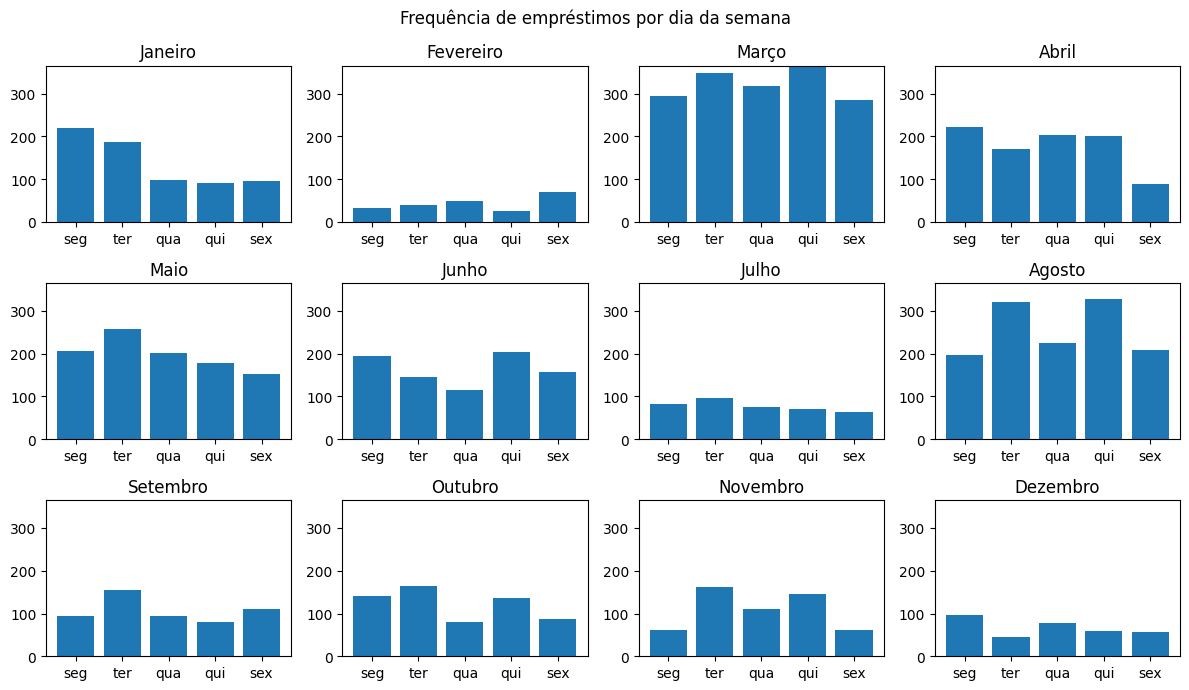

In [10]:
# Cria uma coluna representando cada dia da semana
df['dia-emprestimo'] = df['data-emprestimo'].dt.day_of_week

# Conta os títulos emprestados por dia
df_dia_emprestimo = df[['mes-emprestimo', 'dia-emprestimo', 'titulo']].groupby(['mes-emprestimo', 'dia-emprestimo']).count().reset_index()

# df_dia_emprestimo

fig, axs = plt.subplots(3, 4, figsize=(12, 7))
fig.suptitle('Frequência de empréstimos por dia da semana')
# gera subgráficos por mês
max = df_dia_emprestimo['titulo'].max()
for row in range(3):
  for col in range(4):
    axs[row, col].title.set_text(meses[row * 4 + col])
    axs[row, col].bar(df_dia_emprestimo[df_dia_emprestimo['mes-emprestimo'] == (row * 4 + col) + 1]['dia-emprestimo'], df_dia_emprestimo[df_dia_emprestimo['mes-emprestimo'] == (row * 4 + col) + 1]['titulo'])
    # axs[row, col].bar(df_dia_emprestimo[df_dia_emprestimo['mes-emprestimo'] == (row * 4 + col) + 1]['dia-emprestimo'], (df_dia_emprestimo[df_dia_emprestimo['mes-emprestimo'] == (row * 4 + col) + 1]['titulo']) / (df_dia_emprestimo[df_dia_emprestimo['mes-emprestimo'] == (row * 4 + col) + 1]['titulo']).sum())
    axs[row, col].set_ylim(top=max)

plt.setp(axs, xticks=[0 ,1, 2, 3, 4] ,xticklabels=['seg', 'ter', 'qua', 'qui', 'sex'])
fig.tight_layout()
plt.show()

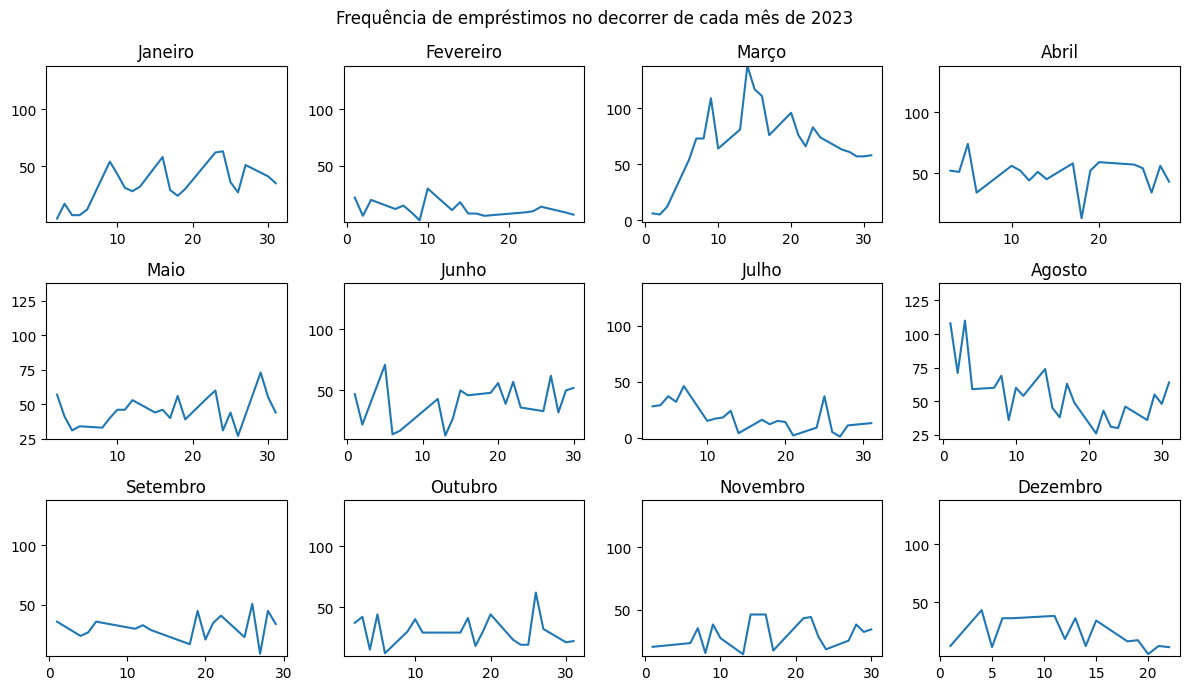

In [11]:
# Conta os títulos emprestados por dia
df_data_emprestimo_dia = df[['data-emprestimo', 'titulo']].groupby(['data-emprestimo']).count().reset_index()

# df_data_emprestimo_dia

fig, axs = plt.subplots(3, 4, figsize=(12, 7))
fig.suptitle('Frequência de empréstimos no decorrer de cada mês de 2023')
# gera subgráficos por mês
max = df_data_emprestimo_dia['titulo'].max()
for row in range(3):
  for col in range(4):
    axs[row, col].title.set_text(meses[row * 4 + col])
    axs[row, col].plot(df_data_emprestimo_dia[df_data_emprestimo_dia['data-emprestimo'].dt.month == (row * 4 + col) + 1]['data-emprestimo'].dt.day, df_data_emprestimo_dia[df_data_emprestimo_dia['data-emprestimo'].dt.month == (row * 4 + col) + 1]['titulo'])
    # axs[row, col].bar(df_data_emprestimo[df_data_emprestimo['mes-emprestimo'] == (row * 4 + col) + 1]['dia-emprestimo'], (df_data_emprestimo[df_data_emprestimo['mes-emprestimo'] == (row * 4 + col) + 1]['titulo']) / (df_dia_emprestimo[df_dia_emprestimo['mes-emprestimo'] == (row * 4 + col) + 1]['titulo']).sum())
    axs[row, col].set_ylim(top=max)
    
fig.tight_layout()
plt.show()

#### Influência dos dias da semana no empréstimo de livros em 2023

No gráfico *Frequência de empréstimos por dia da semana* podemos visualizar que não há predominância visível de um dia da semana como o de maior movimento no empréstimos.

No gráfico seguinte, podemos visualizar a variação dos empréstimo por dia a cada mês, e, embora não haja um padrão claro no comportamento dos empréstimos, vemos claramente a densidade de movimentos durante o mês de Março, o que incita algumas reflexões e perguntas:

> 1. Dos empréstimos de Março, quantos mais atrasos ocorrem em comparação com outros meses de menor movimento, proporcionalmente?
> 2. A disciplina e responsabilidade de devolução dos livros diminui com o passar do ano? Ou seja: livros emprestados no começo do ano são mais ou menos prováveis de atrasar em comparação com livros emprestados na segunda parte do ano?

Total de empréstimos que atrasaram:  3031 ( 34.06766325727774 % )


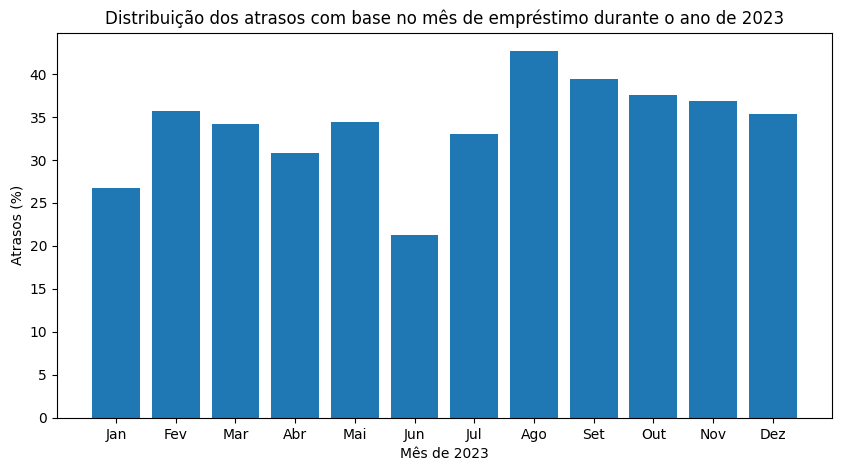

In [12]:
# Cria uma coluna representando se o empréstimo foi atrasado
df['atrasado'] = (df['data-devolucao'] > df['data-para-devolucao']) | (df['data-devolucao'].isna())

count = df[df['atrasado'] == True]['titulo'].count()

print('Total de empréstimos que atrasaram: ', count, '(', count / df.shape[0] * 100,"% )")

# Conta os títulos atrasados por mês
df_atrasados = df[df['atrasado'] == True][['mes-emprestimo', 'titulo']].groupby('mes-emprestimo').count().reset_index()

df_total_emprestimos = pd.merge(df_atrasados, df_data_emprestimo, how="left", on="mes-emprestimo")

# df_total_emprestimos

# plotando gráfico
plt.figure(figsize=(10, 5))
plt.bar(df_total_emprestimos['mes-emprestimo'], (df_total_emprestimos['titulo_x'] / df_total_emprestimos['titulo_y']) * 100)
plt.title("Distribuição dos atrasos com base no mês de empréstimo durante o ano de 2023")
plt.xlabel("Mês de 2023")
plt.xticks(df_total_emprestimos['mes-emprestimo'], meses_abr)
plt.ylabel("Atrasos (%)")
plt.show()

#### Atrasos

O total de emrpéstimos que atrasaram durante o ano de 2023 foram `3031`, o que corresponde a cerca de `34%` dos empréstimos feitos.

Para garantir que as diferentes quantidades de empréstimos não afetem a visualização, o gráfico acima foi feito usando a porcentagem de empréstimos do mês que atrasaram. Vemos que, de fato, existe um acréscimo no número de atrasos no segundo semestre, com o mês de *Agosto* sendo o mês com o maior número de atrasos.


=== Com o Dataframe completo ===

Média de dias de empréstimo (não atrasados): 51.08267984998295
Desvio padrão dos dias de empréstimo (não atrasados): 62.028680356326085

Média de dias de atraso: 62.49692496924969
Desvio padrão dos dias de atraso: 59.835369323181574

Média de dias de atraso: 14.797457974579746
Desvio padrão dos dias de atraso: 35.07866434841852

=== Desconsiderando os primeiros e últimos 10% do dataframe ===

Média de dias de empréstimo (não atrasados): 41.939161784587654
Desvio padrão dos dias de empréstimo (não atrasados): 36.003948815813516

Média de dias de atraso: 45.144372693726936
Desvio padrão dos dias de atraso: 30.019420043751747


<Figure size 1000x500 with 0 Axes>

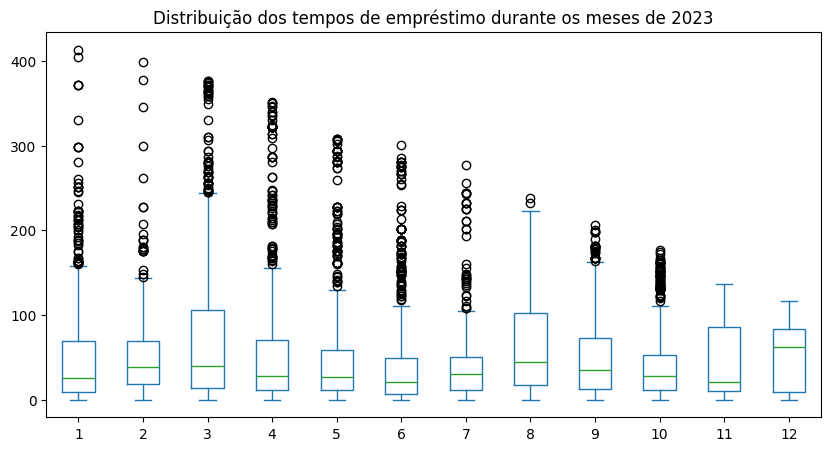

<Figure size 1000x500 with 0 Axes>

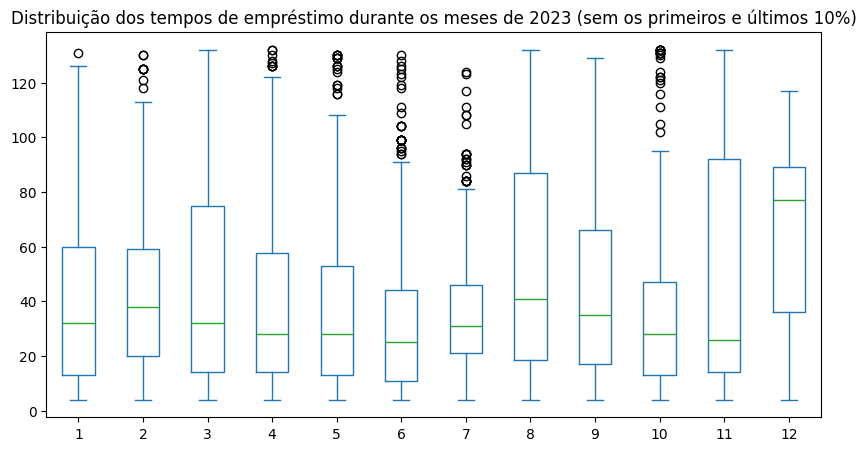

In [42]:
df_tempo_medio = df[df['data-devolucao'].isna() == False][['mes-emprestimo', 'ano', 'atrasado', 'titulo', 'data-emprestimo', 'data-para-devolucao', 'data-devolucao']].reset_index()

df_tempo_medio['tempo-emprestimo'] = df_tempo_medio['data-devolucao'] - df_tempo_medio['data-emprestimo']
df_tempo_medio['tempo-atraso'] = df_tempo_medio['data-devolucao'] - df_tempo_medio['data-para-devolucao']

df_tempo_medio['tempo-emprestimo'] = df_tempo_medio['tempo-emprestimo'].dt.days
df_tempo_medio['tempo-atraso'] = df_tempo_medio['tempo-atraso'].dt.days

df_tempo_medio = df_tempo_medio.sort_values('tempo-emprestimo')

print("\n=== Com o Dataframe completo ===\n")

print("Média de dias de empréstimo (não atrasados):", df_tempo_medio[df_tempo_medio['atrasado'] == False]['tempo-emprestimo'].mean())
print("Desvio padrão dos dias de empréstimo (não atrasados):", df_tempo_medio[df_tempo_medio['atrasado'] == False]['tempo-emprestimo'].std())
print()
print("Média de dias de atraso:", df_tempo_medio[df_tempo_medio['atrasado'] == True]['tempo-emprestimo'].mean())
print("Desvio padrão dos dias de atraso:", df_tempo_medio[df_tempo_medio['atrasado'] == True]['tempo-emprestimo'].std())
print()
print("Média de dias de atraso:", df_tempo_medio[df_tempo_medio['atrasado'] == True]['tempo-atraso'].mean())
print("Desvio padrão dos dias de atraso:", df_tempo_medio[df_tempo_medio['atrasado'] == True]['tempo-atraso'].std())

print("\n=== Desconsiderando os primeiros e últimos 10% do dataframe ===\n")

percentil_inferior = df_tempo_medio['tempo-emprestimo'].quantile(0.1)
percentil_superior = df_tempo_medio['tempo-emprestimo'].quantile(0.9)

print("Média de dias de empréstimo (não atrasados):", df_tempo_medio[(df_tempo_medio['tempo-emprestimo'] > percentil_inferior) & (df_tempo_medio['tempo-emprestimo'] < percentil_superior) & (df_tempo_medio['atrasado'] == False)]['tempo-emprestimo'].mean())
print("Desvio padrão dos dias de empréstimo (não atrasados):", df_tempo_medio[(df_tempo_medio['tempo-emprestimo'] > percentil_inferior) & (df_tempo_medio['tempo-emprestimo'] < percentil_superior) & (df_tempo_medio['atrasado'] == False)]['tempo-emprestimo'].std())
print()
print("Média de dias de atraso:", df_tempo_medio[(df_tempo_medio['tempo-emprestimo'] > percentil_inferior) & (df_tempo_medio['tempo-emprestimo'] < percentil_superior) & (df_tempo_medio['atrasado'] == True)]['tempo-emprestimo'].mean())
print("Desvio padrão dos dias de atraso:", df_tempo_medio[(df_tempo_medio['tempo-emprestimo'] > percentil_inferior) & (df_tempo_medio['tempo-emprestimo'] < percentil_superior) & (df_tempo_medio['atrasado'] == True)]['tempo-emprestimo'].std())

plt.figure(figsize=(10, 5))
# df_tempo_medio[df_tempo_medio['atrasado'] == False].plot.box(column='tempo-emprestimo', by='mes-emprestimo', figsize=(10,5))
df_tempo_medio.plot.box(column='tempo-emprestimo', by='mes-emprestimo', figsize=(10,5))
plt.title("Distribuição dos tempos de empréstimo durante os meses de 2023")
plt.show()

plt.figure(figsize=(10, 5))
df_tempo_medio[(df_tempo_medio['tempo-emprestimo'] > percentil_inferior) & (df_tempo_medio['tempo-emprestimo'] < percentil_superior)].plot.box(column='tempo-emprestimo', by='mes-emprestimo', figsize=(10,5))
plt.title("Distribuição dos tempos de empréstimo durante os meses de 2023 (sem os primeiros e últimos 10%)")
plt.show()

#### Atrasos por mês

A análise feita acerca do tempo de atraso (em dias) revela alguns fatos interessantes. Todavia, vale ressaltar que a dinâmica da biblioteca permite que livros sejam emprestados e fiquem em atraso por tantos dias quanto o aluno demorar para devolvê-los, gerando alguns registros com tempos de atraso altíssimos. Esses *outliers* são removidos em um cálculo comparativo da média e desvio-padrão que considera tanto o DataFrame completo quanto o DataFrame sem os primeiros e últimos 10% dos dados ordenados por tempo de empréstimo, ou seja: os tempos de empréstimos mais curtos e os mais longos são removidos.

Os resultados mostram uma média de cerca de 41 (*versus* 51 no DataFrame completo) dias para os empréstimos que não atrasaram, implicando seguidas renovações do empréstimo. Por outro lado, temos uma média de 45 (*versus* 62 no DataFrame completo) dias de empréstimo para os empréstimos que atrasaram. Esse valor é próximo o bastante para nos fazer pensar que, diferente do esperado, o tempo de empréstimo não é ilustrativo da possibilidade de um empréstimo atrasar ou não. Além disso, os desvios-padrão indicam que há uma razável variação nos dados em relação à média, o que fica mais claro nos gráficos acima.

{'Cálculo': 680, 'Equações diferenciais': 602, 'Matemática': 507, 'Numeros reais': 482, 'Fourier, Séries de': 445, 'Funções de variáveis reais': 438, 'Probabilidades': 323, 'Termodinâmica': 300, 'Estatística matemática': 300, 'Geometria analítica': 287, 'Matemática--Estudo e ensino': 280, 'Matemática--Problemas, exercícios, etc': 242, 'Física': 240, 'Cálculo vetorial': 240, 'Geografia urbana': 233, 'Química orgânica': 231, 'Ciência da computação': 210, 'Álgebra linear': 202, 'Estatística': 201, 'Arquitetura': 196, 'Mecânica': 195, 'Planejamento urbano': 195, 'Química': 190, 'Geografia humana': 189, 'Eletromagnetismo': 182, 'Literatura americana': 181, 'Cidades e vilas': 179, 'Ficção americana': 157, 'Fisiologia humana': 157, 'Determinantes (Matemática)': 151, 'Ótica': 151, 'Urbanização': 149, 'Trigonometria': 149, 'Cartografia': 143, 'Fisioterapia': 140, 'Logarítmos': 137, 'Geografia': 135, 'Sensoriamento remoto': 133, 'Meio ambiente': 132, 'Eletroquímica': 132, 'Funções (Matemática)':

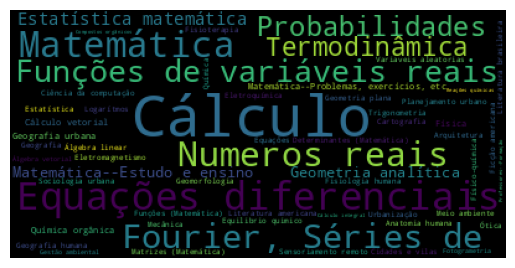

In [14]:
nuvem = {}
all_subjects = ''

for index, row in df[df['assunto'].notnull()].iterrows():
  assuntos = row['assunto'].split(';')

  for assunto in assuntos:
    assunto = re.sub(r'\.$', '', assunto.strip())
    all_subjects = all_subjects + '.' + assunto 
    if assunto in nuvem:
      nuvem[assunto] = nuvem[assunto] + 1
    else:
      nuvem[assunto] = 1
    #break

nuvem_ordenada = dict(sorted(nuvem.items(), key=lambda x:x[1], reverse=True))

print(nuvem_ordenada)
print(len(nuvem_ordenada))

# wordcloud = WordCloud().generate(all_subjects)
wordcloud = WordCloud().generate_from_frequencies(nuvem)

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Assuntos

Os assuntos foram calculados dividindo o conteúdo da coluna `assunto` no caractere ";" e contando as frequências de suas ocorrências em empréstimos.

A nuvem de palavras acima representa graficamente a frequência dos assuntos mais comuns em empréstimos. Aqui está uma das descobertas mais importantes sobre a base de dados até o momento: a maioria dos assuntos mais recorrentes são de uma área específica, ela sendo a área de exatas, matemática, cálculo e os conhecimentos que as circundam.

> Disso brotam diversos questionamentos interessantes sobre a literatura acadêmica e a educação:
>
> - Como são as dinâmicas de cada área do conhecimento acerca dos empréstimos de livros na biblioteca? Os empréstimos são mais pontuais e por curtos períodos de tempo? Ou, por outro lado, são empréstimos feitos cedo e renovados diversas vezes?
> - O que a dependência total na literatura técnica nas disciplinas de Cálculo e Matemática falam sobre a produção de materiais didáticos de apoio e pluralidade de inteligências capazes de compreender os conteúdos desse tipo de disciplina acadêmica?

#### Possíveis estudos exploratórios futuros

Embora o conjunto de dados seja muito tímido e limitado, não possuindo informações contextuais que permitam o cálculo de correlações mais consistentes entre características que afetam os empréstimos ou, de forma simples, a previsão do atraso de empréstimos.

Ainda assim, existem vários pontos que podem ser explorados, como por exemplo:
- quais são os grupos de assuntos dos empréstimos de 2023? 
- como os diversos assuntos fragmentados se agrupam em áreas do conhecimento de forma que seu comportamento possa ser analisado?
- para cada assunto ou grupo de assuntos, qual a idade média da literatura sendo consumida?
- os alunos tem consumido literatura mais moderna ou mais clássica, mais atualizada ou mais antiga?

## Modelo preditivo

> **Dito pelo professor**
> - Lematização (stemming) para agrupar termos
> - remover stop words (a, of, on, for, with, the, at, etc...)
> - Bag of words
> - Transformar os lexemas em features
> - Lematizar usando nltk

### Montagem dos conjuntos para o treinamento

Considerando as deficiências do conjunto de dados que dificultam a construção de um modelo preditivo eficiente, nominalmente:

- a ausência de dados de empréstimos de outros anos;
- a ausência de informações sobre o estudante que emprestou o tomo;

O plano para o modelo preditivo é de selecionar os 100 títulos com maior taxas de atrasos como base, transformando os títulos em *flags* booleanas usando o comando `.get_dummies()`. Em seguida, o conjunto de dados será agrupado por mês de empréstimo (de jan a dez de 2023) e título, de forma que se possa ter frequências diferentes de empréstimos e atrasos para um mesmo livro, divididas por mês. Por fim, vários algoritmos de regressão serão testados no conjunto de dados, mantendo em mente que os conjuntos de treinamento não devem conter dados como quantidade de empréstimos e atrasos.

Os parâmetros do modelo preditivo é a seguinte:

**Tipo de predição:** previsão de uma variável contínua via regressão

**Alvo da predição:** probabilidade de um dado livro atrasar ao ser emprestado (`porcent`)

**Features utilizadas:** `titulo`, `mes-emprestimo`, `atrasado`, `tempo-emprestimo`, `porcent`

In [15]:
# =======================================================================================
# Calcula-se o número de empréstimos por livro por mês para os livros com maiores atrasos
# =======================================================================================

# Frequência de livros e astrasos
df_frequencia_emprestimos = df[['titulo', 'mes-emprestimo', 'atrasado']].groupby(['mes-emprestimo', 'titulo']).count().reset_index()
df_frequencia_emprestimos = df_frequencia_emprestimos.merge(df_tempo_medio[['tempo-emprestimo', 'mes-emprestimo', 'titulo']], on=['mes-emprestimo', 'titulo']).groupby(['mes-emprestimo', 'titulo', 'atrasado']).mean().reset_index().sort_values(by=['mes-emprestimo', 'atrasado'], ascending=False)
df_frequencia_emprestimos

df_frequencia_atrasos = df[df['atrasado'] == True][['titulo', 'mes-emprestimo', 'atrasado']].groupby(['mes-emprestimo', 'titulo']).count().reset_index().sort_values(by=['mes-emprestimo', 'atrasado'], ascending=True)
# Livros com pelo menos 4 atrasos
# df_frequencia_atrasos[df_frequencia_atrasos['atrasado'] >= 4]
df_frequencia_emprestimos = df_frequencia_emprestimos.merge(df_frequencia_atrasos, on=['mes-emprestimo', 'titulo'])

# df_frequencia_atrasos
df_frequencia_emprestimos = df_frequencia_emprestimos.rename(columns={'atrasado_x': 'emprestado', 'atrasado_y': 'atrasado'})
df_frequencia_emprestimos

,mes-emprestimo,titulo,emprestado,tempo-emprestimo,atrasado
0,12,Um curso de cálculo,13,30.333333,5
1,12,Cálculo,8,58.666667,2
2,12,Equações diferenciais,3,0.000000,1
3,12,Estatística básica,3,56.666667,1
4,12,"Posicionamento pelo GNSS : descrição, fundamen...",3,82.000000,3
...,...,...,...,...,...
1847,1,The trickster : a study in American Indian myt...,1,69.000000,1
1848,1,"Topofilia : um estudo da percepção, atitudes e...",1,70.000000,1
1849,1,Técnicas em reabilitação musculoesquelética,1,14.000000,1
1850,1,Urban design : a typology of procedures and pr...,1,14.000000,1


Como os 100 livros mais atrasados incluem livros cuja frequência de atrasos é 4, foram considerados um pouco mais do que 100, de forma que todos os livros com ao menos 4 atrasos fossem considerados para o comando get_dummies.

In [16]:
# Marca o título de todos os livros que não são top 141 como 'Outros'
df_frequencia_emprestimos.loc[df_frequencia_emprestimos['atrasado'] < 4,'titulo'] = 'Outros'

In [17]:
# Cria colunas dummy booleanas com cada título
df_frequencia_atrasos_dummies = pd.get_dummies(df_frequencia_emprestimos,columns=['titulo']).reset_index()

In [18]:
# Calcula a porcentagem de atrasos para cada um dos títulos por mês
df_frequencia_atrasos_dummies['porcent'] = df_frequencia_atrasos_dummies['atrasado'] / df_frequencia_atrasos_dummies['emprestado']

df_frequencia_atrasos_dummies[['mes-emprestimo', 'emprestado', 'atrasado', 'tempo-emprestimo', 'porcent']]

,mes-emprestimo,emprestado,atrasado,tempo-emprestimo,porcent
0,12,13,5,30.333333,0.384615
1,12,8,2,58.666667,0.250000
2,12,3,1,0.000000,0.333333
3,12,3,1,56.666667,0.333333
4,12,3,3,82.000000,1.000000
...,...,...,...,...,...
1847,1,1,1,69.000000,1.000000
1848,1,1,1,70.000000,1.000000
1849,1,1,1,14.000000,1.000000
1850,1,1,1,14.000000,1.000000


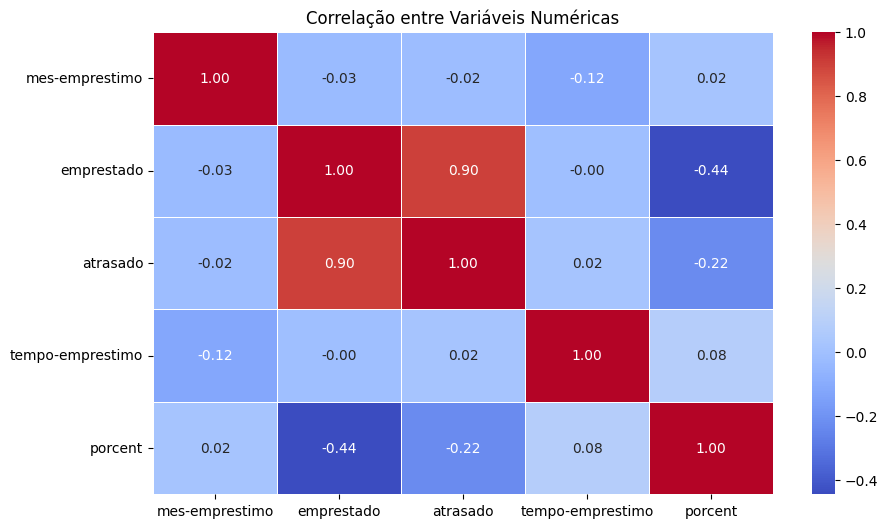

In [19]:
# Correlação entre as variáveis numéricas escolhidas para o modelo
plt.figure(figsize=(10, 6))
sns.heatmap(df_frequencia_atrasos_dummies[['mes-emprestimo', 'emprestado', 'atrasado', 'tempo-emprestimo', 'porcent']].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlação entre Variáveis Numéricas")
plt.show()

In [73]:

# Cria uma máscara para remover as features que não devem estar presentes no treinamento
mask = (df_frequencia_atrasos_dummies.columns != 'porcent') & (df_frequencia_atrasos_dummies.columns != 'emprestado') & (df_frequencia_atrasos_dummies.columns != 'atrasado')
feats_cols = df_frequencia_atrasos_dummies.columns[mask]
# len(feats_cols), len(df_frequencia_atrasos_dummies.columns)

df_frequencia_atrasos_dummies_to_test = df_frequencia_atrasos_dummies.loc[:, feats_cols]

# Separa o conjuntos de dados em conjuntos de teste e de treinamento
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(df_frequencia_atrasos_dummies_to_test, df_frequencia_atrasos_dummies['porcent'], test_size=0.8, random_state=2)

In [74]:
# ========================================================
# Criação de um modelo de predição usando Regressão Linear
# ========================================================
reg_model = LinearRegression()
reg_model.fit(x_train_reg, y_train_reg)
y_pred_reg = reg_model.predict(x_test_reg)

In [75]:
# Cálculo de erros para a Regressão Linear

mse = mean_squared_error(y_test_reg, y_pred_reg)
print("Erro quadrático médio (MSE) para regressão:", mse)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
print("Erro médio absoluto (MAE) para regressão:", mae)

mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg)
print("Erro médio percentual absoluto (MAPE) para regressão:", mape)

Erro quadrático médio (MSE) para regressão: 0.0505063752044304
Erro médio absoluto (MAE) para regressão: 0.1824703949287858
Erro médio percentual absoluto (MAPE) para regressão: 0.37502232856306095


In [76]:
# ===========================================
# Criação de um modelo de predição usando KNN
# ===========================================

from sklearn.neighbors import KNeighborsRegressor


reg_model_knn = KNeighborsRegressor(n_neighbors=5)
reg_model_knn.fit(x_train_reg, y_train_reg)
y_pred_reg_knn = reg_model_knn.predict(x_test_reg)

# Cálculo dos erros do KNN
mse = mean_squared_error(y_test_reg, y_pred_reg_knn)
print("Erro quadrático médio (MSE) para regressão:", mse)

mae = mean_absolute_error(y_test_reg, y_pred_reg_knn)
print("Erro médio absoluto (MAE) para regressão:", mae)

mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg_knn)
print("Erro médio percentual absoluto (MAPE) para regressão:", mape)


Erro quadrático médio (MSE) para regressão: 0.0409067715905157
Erro médio absoluto (MAE) para regressão: 0.12652311454588266
Erro médio percentual absoluto (MAPE) para regressão: 0.28955886028371497


**Regressão Linear e KNN**

Observa-se abaixo que a regressão linear possui elementos que passam do teto de possibilidade (mais de 100% de chance de atraso), e que a predição do KNN é mais precisa por uma pequena margem, de acordo com uma comparação entre os erros quadráticos médios e erros percentuais absolutos.

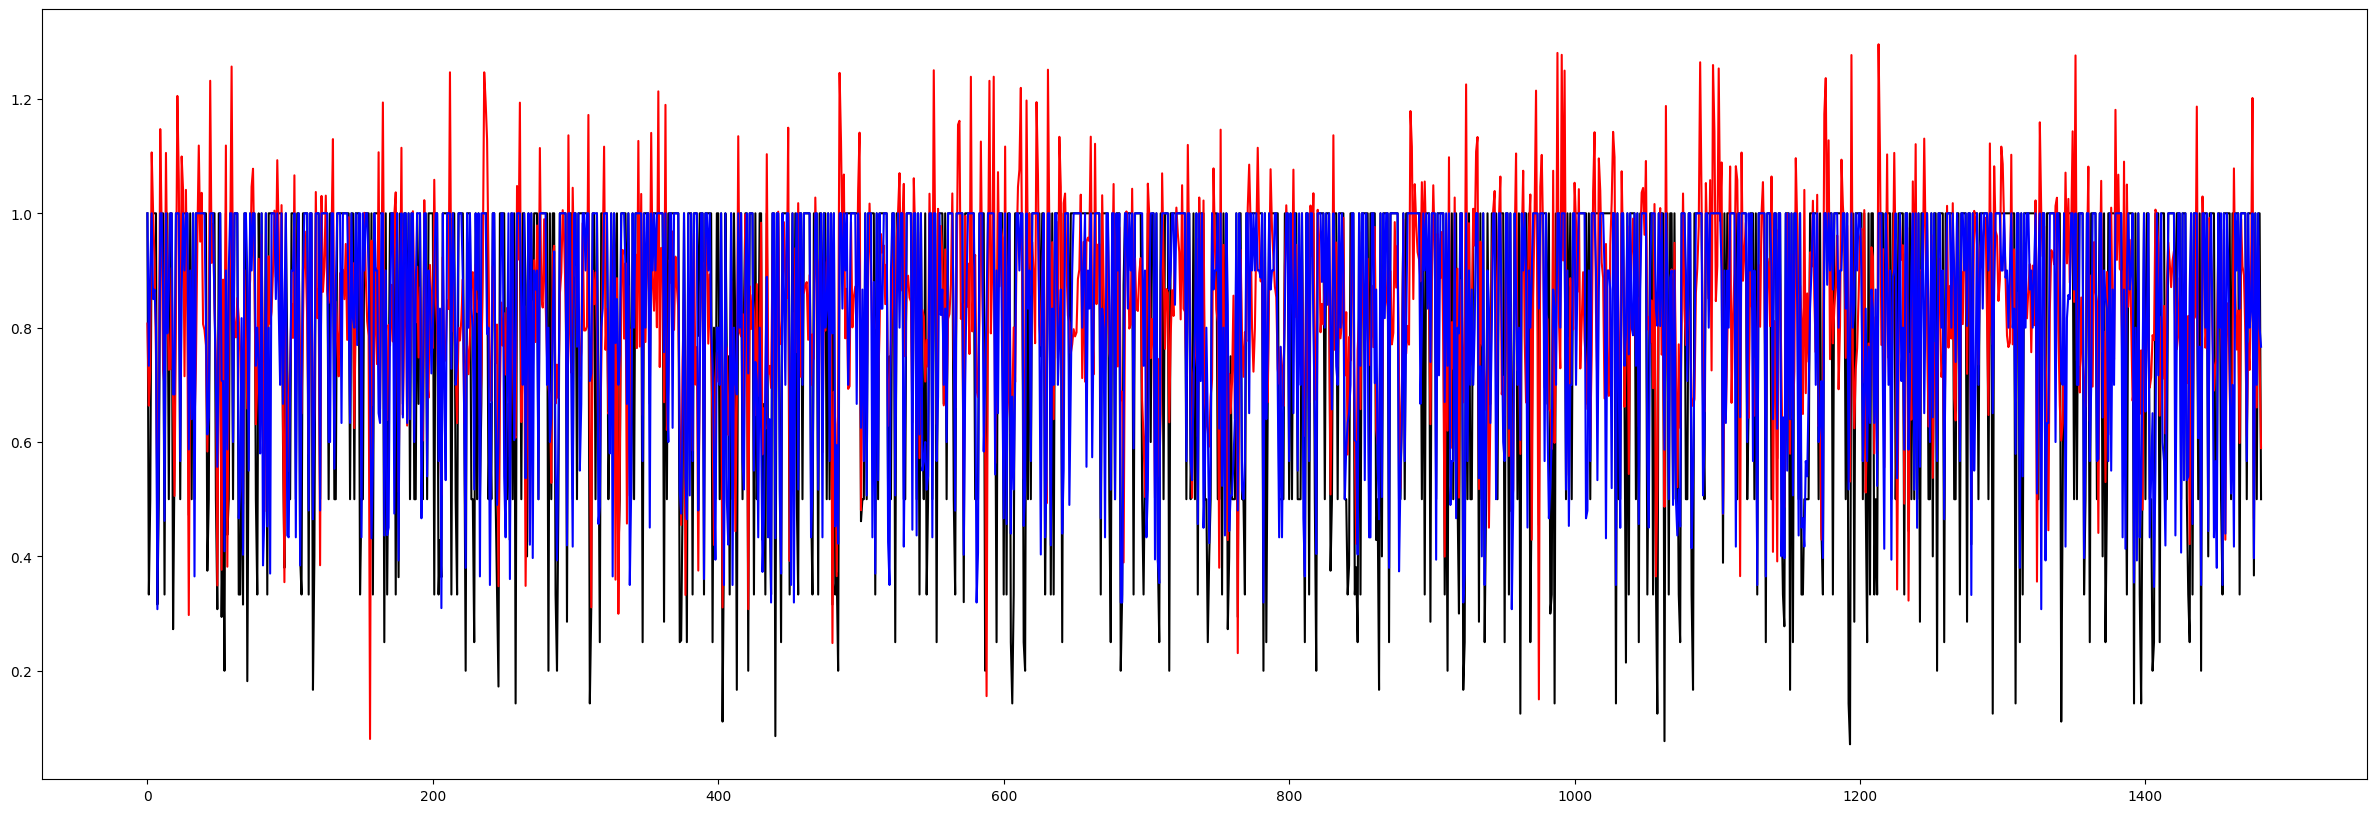

In [77]:
plt.figure(figsize=(30,10))
plt.plot(range(0,len(y_pred_reg)), y_test_reg, color='black')
plt.plot(range(0,len(y_pred_reg)), y_pred_reg, color='red')
plt.plot(range(0,len(y_pred_reg)), y_pred_reg_knn, color='blue')
plt.show()

In [78]:
# ==========================================================
# Criação de um modelo de predição usando Árvores de Decisão
# ==========================================================

from sklearn.tree import DecisionTreeRegressor

reg_model_dt = DecisionTreeRegressor()
reg_model_dt.fit(x_train_reg, y_train_reg)
y_pred_reg_dt = reg_model_dt.predict(x_test_reg)
y_pred_train_reg_dt = reg_model_dt.predict(x_train_reg)

# Cálculo de erros da Árvore de Regressão
mse = mean_squared_error(y_test_reg, y_pred_reg_dt)
print("Erro quadrático médio (MSE) para regressão:", mse)

mae = mean_absolute_error(y_test_reg, y_pred_reg_dt)
print("Erro médio absoluto (MAE) para regressão:", mae)

mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg_dt)
print("Erro médio percentual absoluto (MAPE) para regressão:", mape)
print()
# Cálculo de erros da Árvore de Regressão (conjunto de treino)
mse = mean_squared_error(y_train_reg, y_pred_train_reg_dt)
print("Erro quadrático médio (MSE) para regressão (treino):", mse)

mae = mean_absolute_error(y_train_reg, y_pred_train_reg_dt)
print("Erro médio absoluto (MAE) para regressão (treino):", mae)

mape = mean_absolute_percentage_error(y_train_reg, y_pred_train_reg_dt)
print("Erro médio percentual absoluto (MAPE) para regressão (treino):", mape)

Erro quadrático médio (MSE) para regressão: 0.03663831723520654
Erro médio absoluto (MAE) para regressão: 0.08484284544154887
Erro médio percentual absoluto (MAPE) para regressão: 0.2014405302775612

Erro quadrático médio (MSE) para regressão (treino): 0.0
Erro médio absoluto (MAE) para regressão (treino): 0.0
Erro médio percentual absoluto (MAPE) para regressão (treino): 0.0


**Árvore de Decisões**

Os erros médios da árvore de decisões são um pouco melhores que os erros da regressão KNN.

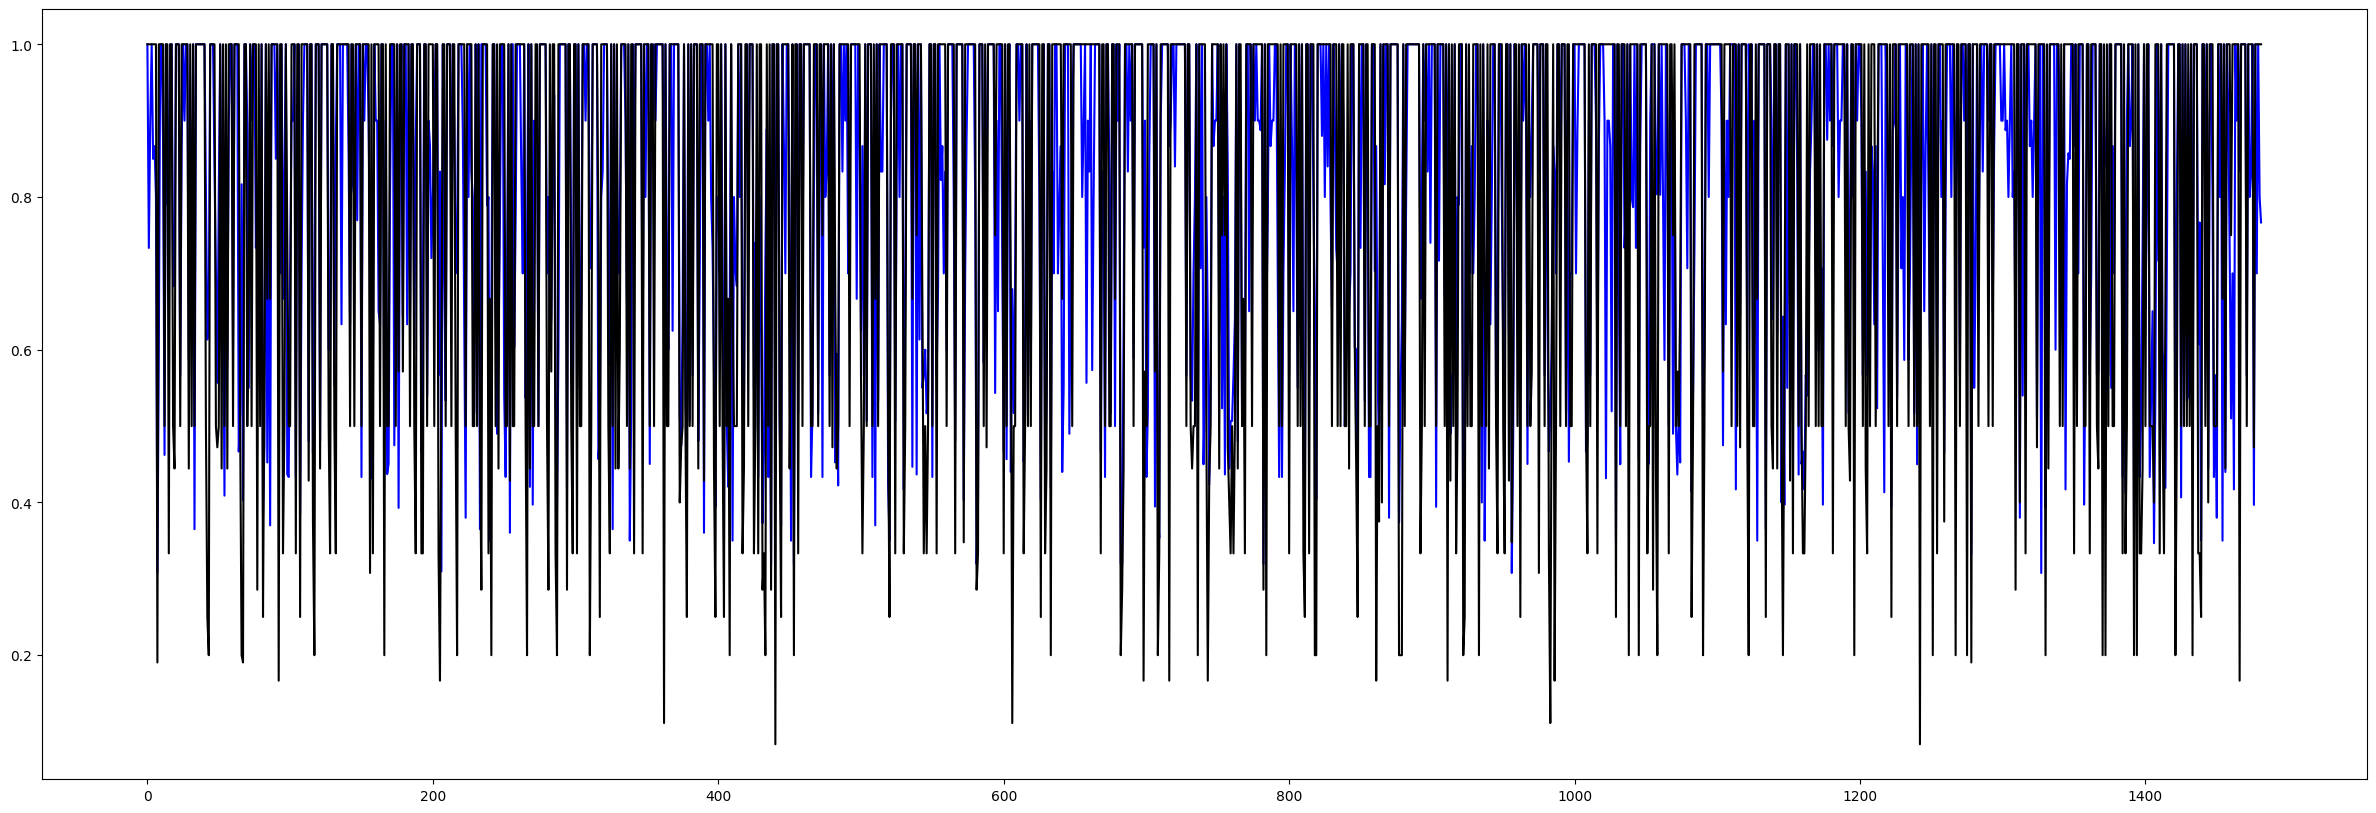

In [79]:
plt.figure(figsize=(30,10))
plt.plot(range(0,len(y_pred_reg)), y_pred_reg_knn, color='blue')
plt.plot(range(0,len(y_pred_reg)), y_pred_reg_dt, color='black')
plt.show()

In [80]:
# ==============================================================
# Criação de um modelo de predição usando Regressão RandomForest
# ==============================================================
from sklearn.ensemble import RandomForestRegressor

reg_model_rf = RandomForestRegressor(n_estimators=100)
reg_model_rf.fit(x_train_reg, y_train_reg)
y_pred_reg_rf = reg_model_rf.predict(x_test_reg)

In [81]:
# Cálculo de erros do RandomForest
mse = mean_squared_error(y_test_reg, y_pred_reg_rf)
print("Erro quadrático médio (MSE) para regressão:", mse)

mae = mean_absolute_error(y_test_reg, y_pred_reg_rf)
print("Erro médio absoluto (MAE) para regressão:", mae)

mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg_rf)
print("Erro médio percentual absoluto (MAPE) para regressão:", mape)


Erro quadrático médio (MSE) para regressão: 0.027860840484088024
Erro médio absoluto (MAE) para regressão: 0.10304624701535468
Erro médio percentual absoluto (MAPE) para regressão: 0.2377233134716395


**RandomForest**

Utilizando 100 para o número de árvores aleatórias geradas, percebe-se uma ligeira queda de eficiência da predição, embora diminuta.

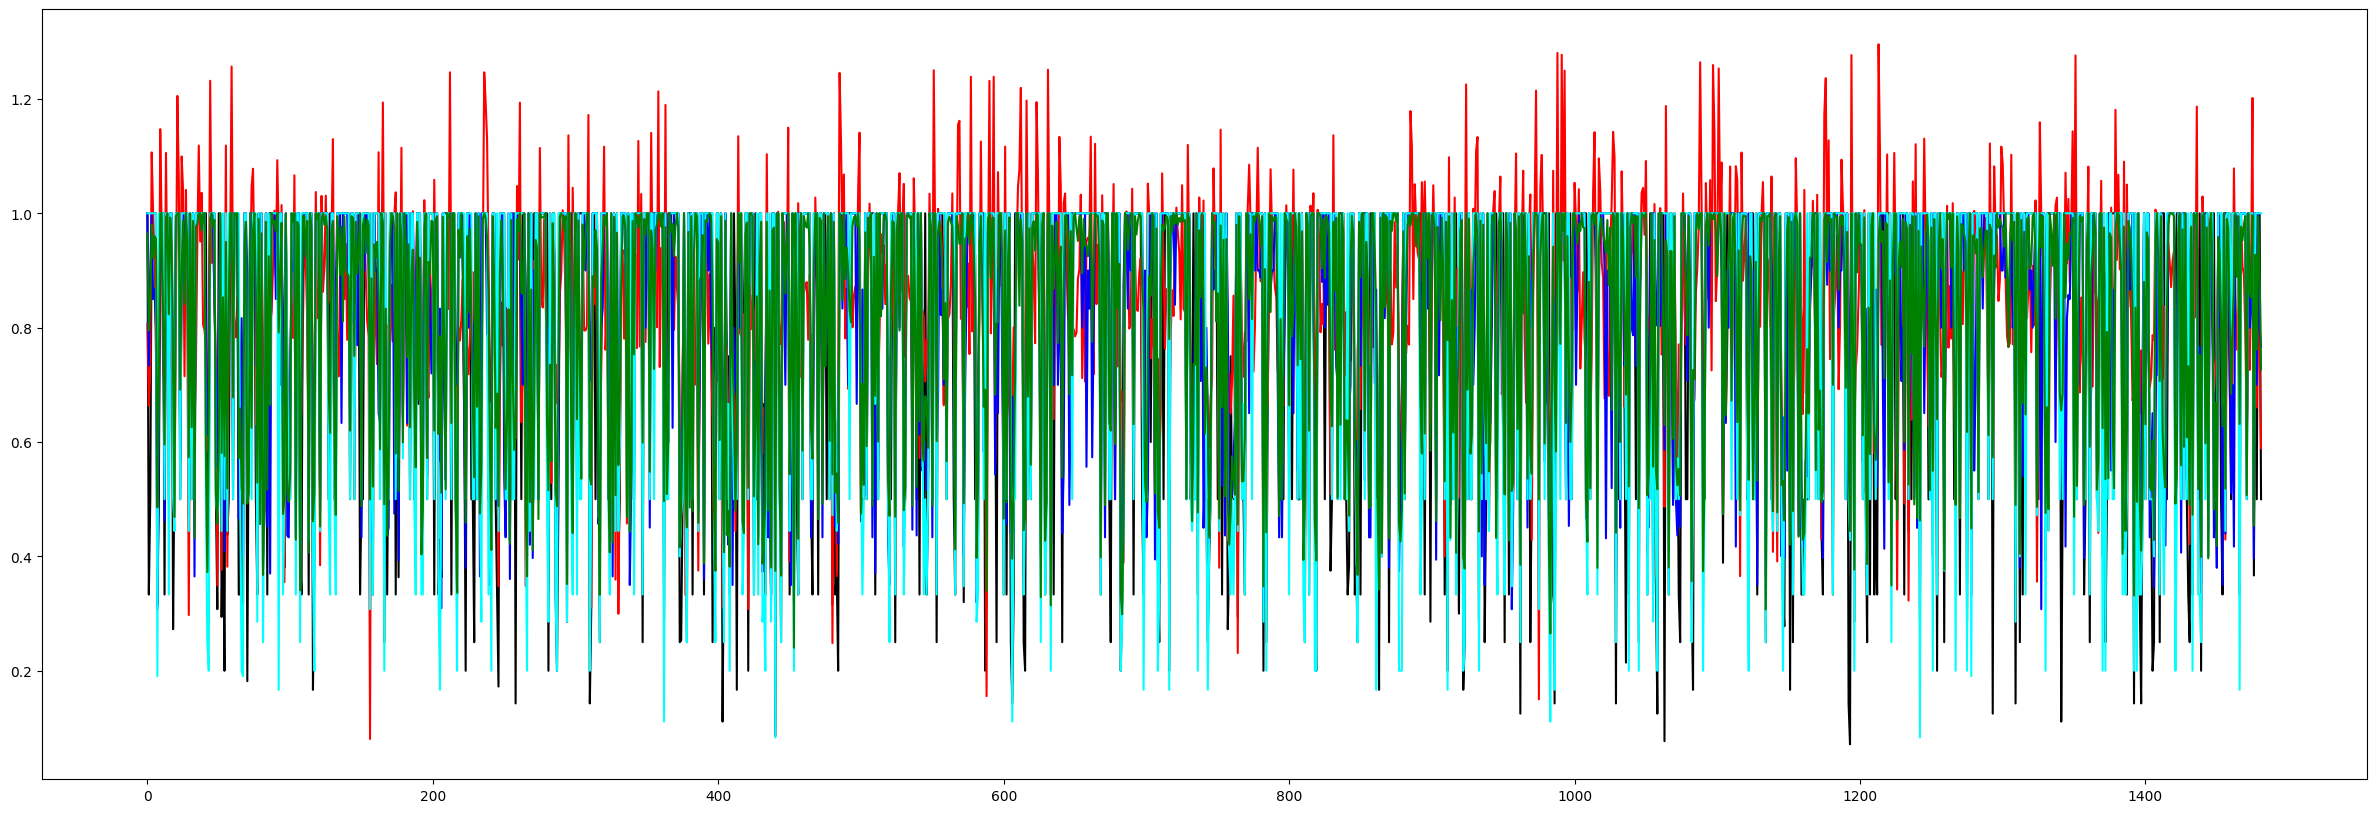

In [82]:
plt.figure(figsize=(30,10))
plt.plot(range(0,len(y_pred_reg)), y_test_reg, color='black')
plt.plot(range(0,len(y_pred_reg)), y_pred_reg, color='red')
plt.plot(range(0,len(y_pred_reg)), y_pred_reg_knn, color='blue')
plt.plot(range(0,len(y_pred_reg)), y_pred_reg_dt, color='cyan')
plt.plot(range(0,len(y_pred_reg)), y_pred_reg_rf, color='green')
plt.show()